# IFT870 - TP4

Auteur : Aurélien Vauthier (19 126 456)

In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, make_scorer, silhouette_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scipy.spatial.distance import cdist, pdist, squareform
from itertools import product
from tqdm import tqdm
import numpy as np
import pandas as pd
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Chargement d'un ensemble de données de faces de personnages connus
from sklearn.datasets import fetch_lfw_people

In [3]:
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [4]:
# format des images et nombres de clusters
print("Format des images: {}".format(faces.images.shape))
print("Nombre de classes: {}".format(len(faces.target_names)))

Format des images: (3023, 87, 65)
Nombre de classes: 62


In [5]:
# nombre de données par cluster
nombres = np.bincount(faces.target)
for i, (nb, nom) in enumerate(zip(nombres, faces.target_names)):
    print("{0:25} {1:3}".format(nom, nb), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

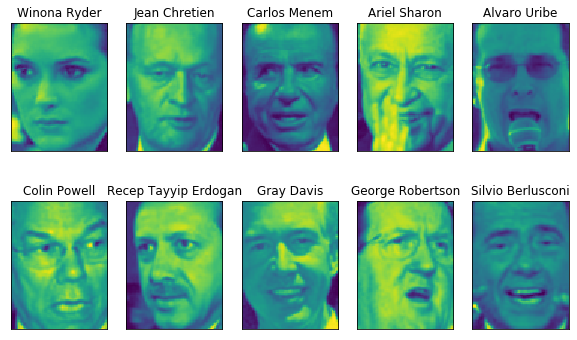

In [6]:
# Affichage des 10 premières faces
fig, axes = plt.subplots(2, 5, figsize=(10, 6),
                         subplot_kw={'xticks': (), 'yticks': ()})
for nom, image, ax in zip(faces.target, faces.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(faces.target_names[nom])

*Pour commencer, les données ne sont pas équilibrées car certains personnages sont beaucoup
plus représentés que d’autres. Pour pallier à cela, filter les données pour ne conserver que
40 visages au maximum par personne.*

In [7]:
# Convert data array to DataFrame and append targets
data = pd.DataFrame(faces.data)
data["target"] = faces.target

# keep the first 40 data for each target
data = data.groupby("target").head(40)

# show results
data.head()

,0,1,2,3,4,5,6,7,8,9,...,5646,5647,5648,5649,5650,5651,5652,5653,5654,target
0,57.000000,60.333332,78.000000,120.666664,156.000000,178.000000,195.333328,210.666672,221.333328,222.333328,...,41.666668,17.333334,15.666667,20.000000,19.000000,18.333334,17.333334,16.666666,22.666666,61
1,66.666664,80.666664,88.666664,68.000000,63.333332,96.000000,115.333336,127.666664,139.000000,148.333328,...,25.333334,18.666666,11.666667,8.666667,8.000000,8.666667,8.666667,8.333333,9.333333,25
2,18.666666,14.333333,15.000000,13.666667,14.666667,23.333334,55.333332,92.666664,125.666664,154.666672,...,253.000000,251.333328,240.666672,172.666672,47.666668,20.666666,22.666666,22.666666,25.666666,9
3,76.666664,113.666664,172.000000,201.666672,199.333328,190.333328,177.000000,167.666672,167.666672,171.333328,...,82.000000,115.000000,131.666672,137.333328,136.666672,138.333328,140.666672,143.000000,143.333328,5
4,79.000000,70.000000,70.333336,81.666664,99.000000,126.000000,144.333328,156.666672,164.333328,168.666672,...,88.666664,91.000000,90.000000,89.666664,85.333336,83.000000,80.333336,74.000000,64.333336,1


*Ensuite, appliquer une réduction de la dimension à 100 composantes et une normalisation
en utilisant le modèle `PCA()` de `sklearn` avec les options `whiten=True` et `random_state=0`.*

In [8]:
pca = PCA(100, whiten=True, random_state=0)

X = pca.fit_transform(data.drop("target", axis=1))
y = data["target"]
data = pd.concat([pd.DataFrame(X, index=y.index), y], axis=1)

# show results
data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
0,-0.572747,1.129339,-0.253437,0.406830,-0.322095,0.482812,0.791779,2.616389,0.904369,2.029480,...,0.256525,-0.644238,-1.168209,1.492557,-1.010132,-0.123555,0.245787,0.011851,-0.056364,61
1,-0.149055,1.281452,-0.067489,-1.866701,0.671637,1.216258,-0.983363,-0.786933,1.808544,-0.438928,...,-0.188852,0.588642,1.440861,0.129968,-0.082948,0.651880,-0.079618,0.179046,-1.233706,25
2,1.597873,-1.040395,-0.804712,-1.691284,-0.113194,1.413717,1.056679,-0.407075,1.360608,0.458857,...,0.615211,1.621387,0.285978,0.635868,0.819362,-2.521142,-0.551872,-0.185830,0.266285,9
3,-0.591691,0.884457,-0.314161,-1.731240,1.691283,0.200454,-1.464200,-0.620295,-1.586466,1.370098,...,1.359766,-0.628874,-1.126080,-1.753929,1.550735,0.064842,-0.902004,0.229844,-1.794110,5
4,1.030595,0.377681,-0.688361,1.014538,0.879269,-0.829059,0.714597,-0.891114,1.494667,1.865828,...,0.041977,1.224686,-0.137619,-1.342712,-0.589966,-0.420956,-1.178567,1.649686,1.220989,1


## Analyse avec K-Means

*Implémenter la méthode du coude (Elbow method) pour essayer de déterminer un
nombre de clusters optimals dans l’ensemble suivant [40, 45, 50, 55, 60, ..., 80] sans
utiliser les données réelles (noms associés aux images). La mesure de score à utiliser
pour tout nombre de clusters k est la suivante : moyenne des distances euclidiennes des
données à leur plus proche centre de cluster pour le modèle à k clusters. Analyser le
résultat et donner vos conclusions.*

Computing mean of min distances to closest centroid...: 100%|██████████| 9/9 [00:14<00:00,  1.66s/it]


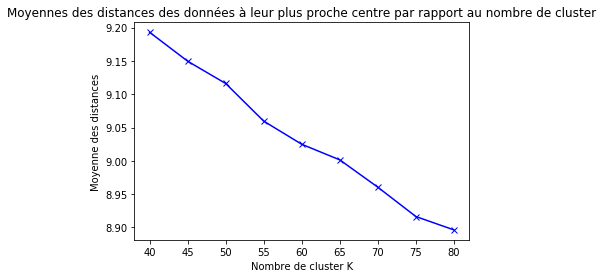

In [9]:
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
k_list = range(40, 81, 5)
mean_min_dists = []

for k in tqdm(k_list, desc="Computing mean of min distances to closest centroid..."):
    kmean = KMeans(n_clusters=k, n_jobs=-1, random_state=0)
    kmean.fit(X)

    distances = cdist(X, kmean.cluster_centers_, "euclidean")
    mean_min_dist = np.mean(np.min(distances, axis=1))
    mean_min_dists.append(mean_min_dist)

plt.plot(k_list, mean_min_dists, 'bx-')
plt.xlabel("Nombre de cluster K")
plt.ylabel("Moyenne des distances")
plt.title("Moyennes des distances des données à leur plus proche centre par rapport au nombre de cluster")
plt.show()

D'après les résultats du graphique ci-dessus, nous pouvons observer deux faible "coudes" autour des valeurs 55/60 et de
la valeur 75. Nous pourrions donc tenter de regarder les clusters formés à ces valeurs manuellement pour vérifier leur
potentiel.

Nous pouvons expliquer ces faibles résultats par la
[malédiction de la dimensionnalité](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension). En effet, on peut
constater que lorsque le nombre de dimensions augmente la distance entre les points tend à s'uniformiser. Cela rend
ainsi les calculs de distances moins performant et moins significatif.

*Appliquer une approche de validation croisée en divisant les données en 10 parties et en
utilisant les données réelles et le score `Adjusted_Rand_Index` (ARI) pour déterminer
un nombre de clusters optimal dans l’ensemble [40, 45, 50, 55, 60, ..., 80]. Analyser le
résultat et donner vos conclusions.*

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


Best k fond : 80


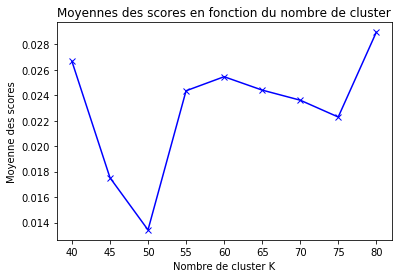

In [10]:
model = KMeans(n_jobs=-1, random_state=0)
param_grid = {
    "n_clusters": k_list
}

# convert metric to scorer
scorer_ARI = make_scorer(adjusted_rand_score)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
best_kmean = GridSearchCV(model, param_grid, cv=cv, scoring=scorer_ARI, n_jobs=-1, verbose=1)
best_kmean.fit(X, y)

print(f"Best k fond : {best_kmean.best_params_['n_clusters']}")

plt.plot(k_list, best_kmean.cv_results_["mean_test_score"], 'bx-')
plt.xlabel("Nombre de cluster K")
plt.ylabel("Moyenne des scores")
plt.title("Moyennes des scores en fonction du nombre de cluster")
plt.show()

Nous pouvons remarquer que, si on retire le paramètre `random_state`, les résultats changent à chaque exécution et ces
résultats sont parfois oscillants, rendant la précision de la validation croisée douteuse.

Nous pouvons aussi noter que les potentiels meilleurs clusterings sont cette fois-ci obtenus pour des valeurs de
`n_clusters` à 40, 60 et 80 (ce dernier étant d'après notre mesure de score le meilleur clustering). Là encore, une
vérification manuelle de la sémantique des clusters formés serait nécessaire pour les évaluer plus précisément.

Ces résultats semblent donc confirmer la difficulté de classifier ces données. 

## Analyse avec DBSCAN

*Utiliser le coéfficient de silhouette pour déterminer les meilleurs valeurs de paramètres
(nombre minimum d’éléments dans un cluster `min_samples`, et rayon du voisinage autour
de chaque donnée `eps`) pour la méthode DBSCAN avec `min_samples` dans l’intervalle
[1, ..., 10] et eps dans l’intervalle [5, ..., 15]*

Searching best eps and min_samples for DBSCAN: 100%|██████████| 121/121 [00:36<00:00,  3.33it/s]

Best eps = 15, best min_samples = 3
Number of cluster(s) for the best model : 1


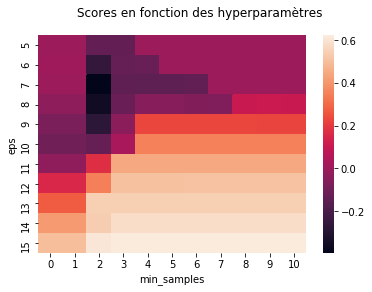

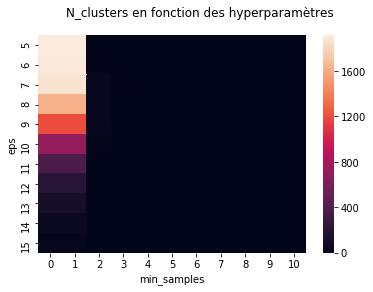

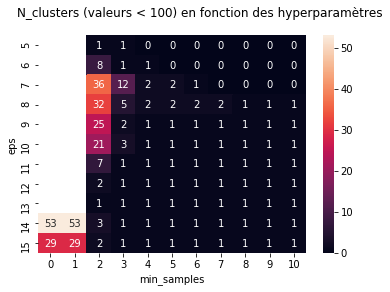

In [11]:
# pre-compute pair-wise distances
distances = squareform(pdist(X))

eps_list = range(5, 16)
min_samples_list = range(11)

scores = []
n_clusters = []
best_dbscan = None
best_dbscan_score = 0
best_dbscan_n_cluster = 0
best_dbscan_params = None
for eps, min_samples in tqdm(product(eps_list, min_samples_list), total=len(eps_list)*len(min_samples_list),
                             desc="Searching best eps and min_samples for DBSCAN"):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    predict = dbscan.fit_predict(X, y)

    score = silhouette_score(distances, predict) if len(np.unique(predict)) > 1 else 0  # if only noise found, score = 0
    n_cluster = len(np.unique(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)   # we don't count noise

    scores.append(score)
    n_clusters.append(n_cluster)
    if score > best_dbscan_score:
        best_dbscan_score = score
        best_dbscan = dbscan
        best_dbscan_params = (eps, min_samples)
        best_dbscan_n_cluster = n_cluster

print(f"Best eps = {best_dbscan_params[0]}, best min_samples = {best_dbscan_params[1]}")
print(f"Number of cluster(s) for the best model : {best_dbscan_n_cluster}")

def plot_heatmap_of_hyperparam(values, title, annot=False):
    values = np.reshape(values, (len(eps_list), len(min_samples_list)))
    sns.heatmap(values, xticklabels=min_samples_list, yticklabels=eps_list, annot=annot)
    plt.suptitle(title)
    plt.xlabel("min_samples")
    plt.ylabel("eps")
    plt.show()


# plot scores heat map
plot_heatmap_of_hyperparam(scores, "Scores en fonction des hyperparamètres")

# plot n_clusters heat map
plot_heatmap_of_hyperparam(n_clusters, "N_clusters en fonction des hyperparamètres")

# plot n_clusters heat map for values less  than 100
n_clusters = np.where(np.array(n_clusters) < 100, n_clusters, np.nan)
plot_heatmap_of_hyperparam(n_clusters, "N_clusters (valeurs < 100) en fonction des hyperparamètres", annot=True)

D'après les résultats ci-dessus, on peut remarquer que les meilleurs scores de silhouette sont obtenu pour un
`eps` élevé et un `min_sample` moyen à élevé. Nous pouvons ainsi déduire de ces résultats que les meilleurs clusters au
sens du coefficient de silhouette sont les plus gros. Il semble aussi que les valeurs de score soient plus sensibles aux
modifications d'`eps` que de `min_samples`.

Cependant, si on observe le nombre de clusters, on s'aperçoit que les clusterings avec les meilleurs scores sont aussi
souvent ceux qui ont un nombre de clusters très faible. Cette observation est assez contre-intuitive car on s'attend en
général à obtenir $\sqrt{n}$ clusters, ce qui pour notre cas correspondrait à $\sqrt{1916} \approx 44$. Par conséquent,
il serait donc intéressant de vérifier les clusterings avec plus de clusters qui pourraient ainsi mieux séparer les
données.

On peut aussi noter la présence de clusterings sans cluster (ou plutôt uniquement composés de bruit) lorsque les valeurs
d'`eps` sont faibles et les valeurs de `min_samples` moyennes à élevées. Ces résultats permettent de démontrer que la
plupart des points sont assez éloignés les uns des autres et qu'il n'existe pas de groupe concentré d'observation.

*En fixant le paramètre `min_samples = 3`, appliquer DBSCAN en faisant varier le paramètre
`eps` dans l’intervalle [5, ..., 15]. Observer des échantillons d’images des clusters
pour chaque rayon dans l’intervalle [5, ..., 15], et tenter de déterminer la signification
sémantique des clusterings estimés. Elle peut correspondre à un clustering suivant les
personnages, ou suivant d’autres caractéristiques commune comme l’orientation du visage,
l’arrière plan, le port de lunette, etc. Lister vos conclusions pour chaque valeur de
`eps`.*

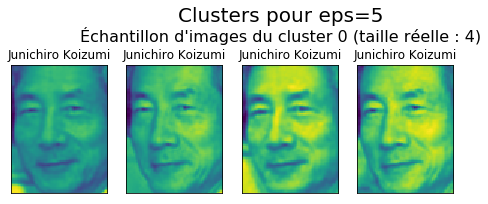

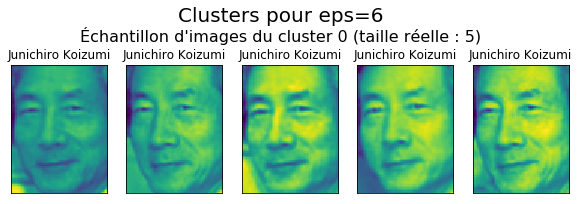

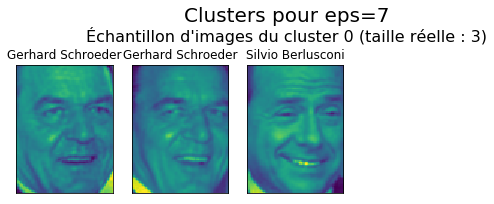

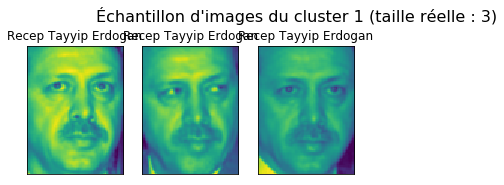

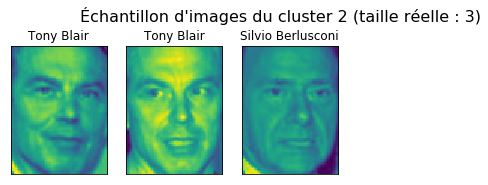

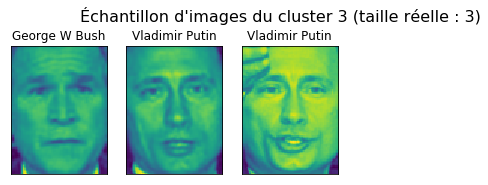

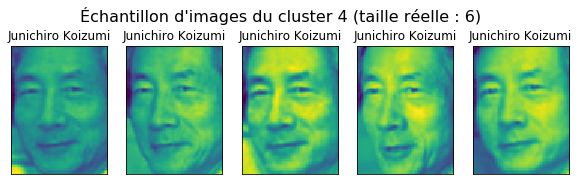

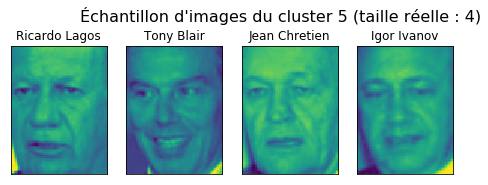

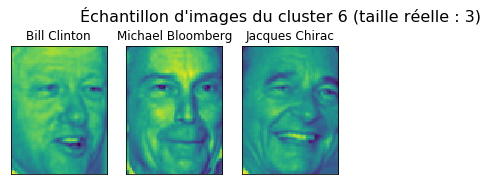

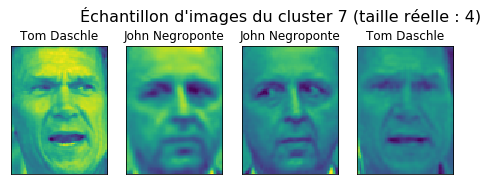

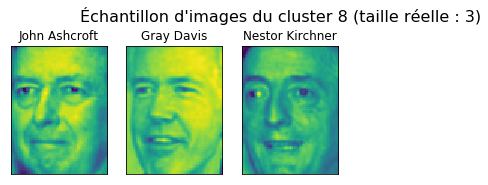

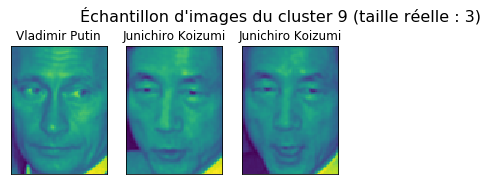

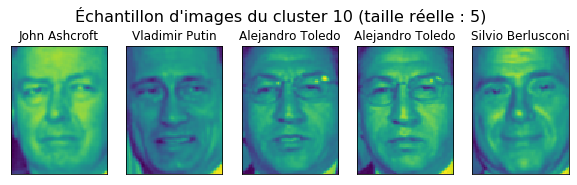

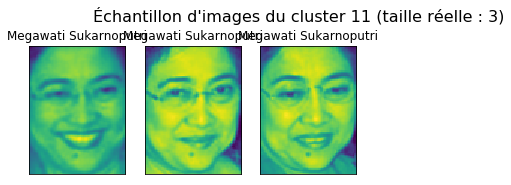

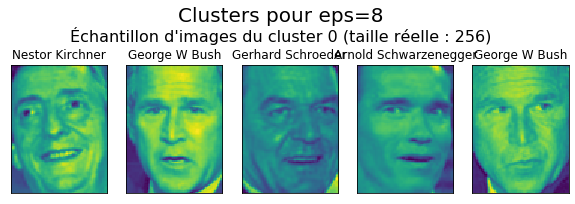

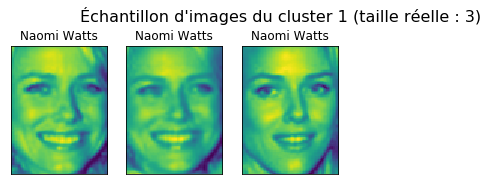

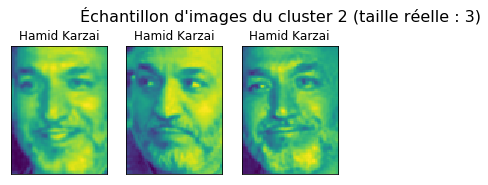

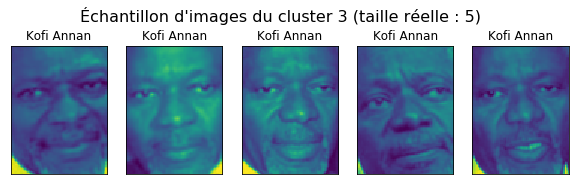

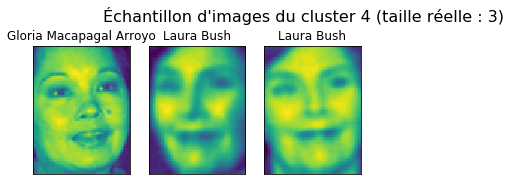

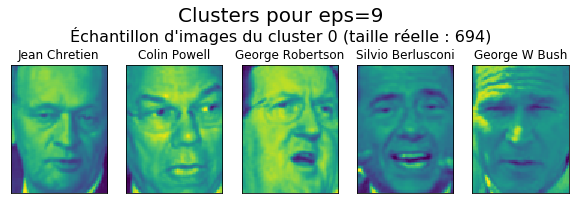

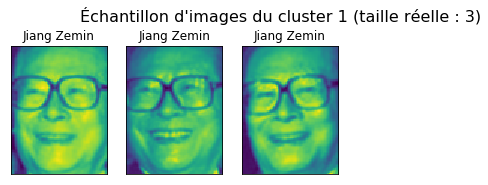

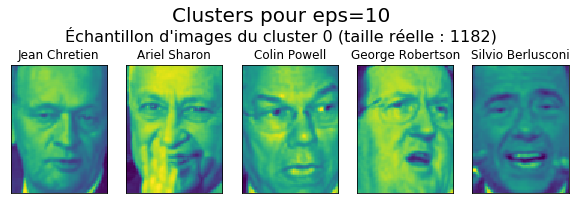

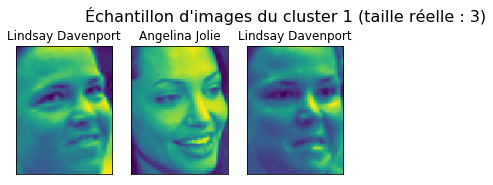

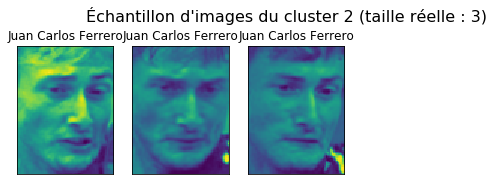

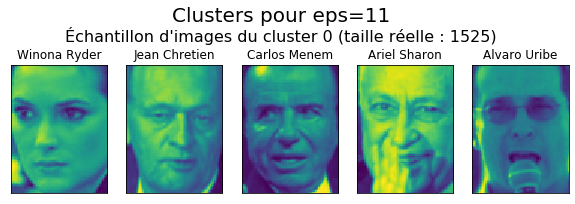

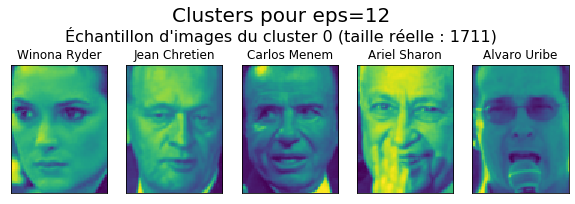

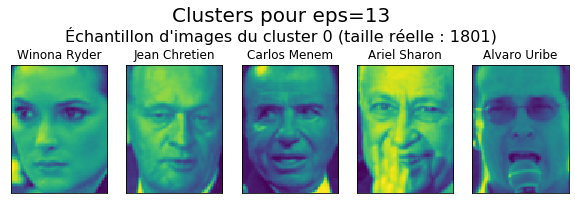

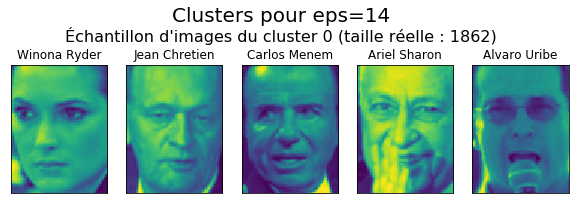

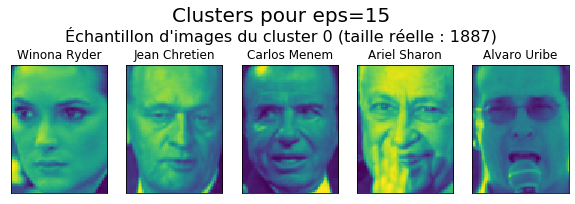

In [12]:
# remove warning printing more than 20 images
plt.rcParams.update({'figure.max_open_warning': 0})

def show_cluster_samples(data, X, y, eps):
    predict = DBSCAN(eps=eps, min_samples=3, n_jobs=-1).fit_predict(X, y)
    data["cluster"] = predict

    image_count = 5

    for cluster, clusterData in data.groupby("cluster"):
        if cluster == -1:
            continue

        fig, axes = plt.subplots(ncols=image_count, figsize=(10, 3), subplot_kw={'xticks': (), 'yticks': ()})
        fig.suptitle(f"Échantillon d'images du cluster {cluster} (taille réelle : {clusterData.shape[0]})", fontsize=16)

        if cluster == 0:
            fig.text(0.5, 1, f"Clusters pour eps={eps}", horizontalalignment='center', fontsize=20)

        for image in range(image_count):
            if image >= clusterData.shape[0]:
                axes[image].set_visible(False)
                continue

            row_index = clusterData.index[image]
            axes[image].imshow(faces.images[row_index])
            axes[image].set_title(faces.target_names[clusterData["target"][row_index]])


for eps in eps_list:
    show_cluster_samples(data, X, y, eps)

Pour tous les clusters nous avons choisi de ne pas afficher les bruits (données pour lesquelles la valeur du 
cluster est égale à `-1`). En effet, bien qu'elles soient regroupées dans un même ensemble, ces données ne présentent 
pas de caractéristiques communes mis à part d'être considérées différentes de toutes les autres données par `DBSCAN` 

### Analyse pour `eps=5`

Nous observons ici un seul cluster composé de 4 photos de la même personne : `Junichiro Koizumi`.

### Analyse pour `eps=6`

Là encore, nous observons le cluster trouvé précédemment mais cette fois-ci, avec une photo de plus de la même personne.

### Analyse pour `eps=7`

Pour cette valeur d'`eps` nous observons une nette amélioration. En effet, l'algorithme a réussi à identifier 12 
groupes de photos. `DBSCAN` semble ici avoir regroupé les photos selon l'orientation du visage. On note tout de même 
que les clusters sont tous assez petits (6 photos pour le gros cluster). 

### Analyse pour `eps=8`

À partir de cette valeur d'`eps`, il semble que `DBSCAN` ait plus de mal à séparer les visages. En effet, bien qu'on
puisse noter la présence de 4 petits clusters (avec 5 photos au maximum), on remarque aussi l'émergence d'un grand
cluster (avec 256 photos). De plus, les petits clusters semblent ne plus uniquement regrouper des personnes selon
l'orientation du visage mais aussi selon la personne (seul le dernier cluster est composé de deux personnalités
différentes). A contrario le premier cluster regroupe beaucoup de personnalités différentes dans des orientations du
visage différentes et avec des traits de caractères (comme la présence de rides / cernes, la bouche ouverte...)
différents. On peut donc imaginer que la valeur d'`eps` est trop grande et induit de trop grand regroupement.

### Analyse pour `eps=9`

Les résultats observés précédemment se confirment avec la présence ici d'un cluster encore plus grand (694 images) et
d'un petit cluster (3 images) composé uniquement de la personnalité `Jiang Zemin` possédant des traits assez spécifiques
(en particulier de très grandes lunettes bien visible).

### Analyse pour `eps=10`

Légère amélioration ici des résultats avec 2 petits clusters (3 photos chacun) avec une orientation du visage
intra-cluster similaire et avec le premier cluster composé de différentes personnalités. En revanche, nous notons aussi
que le gros cluster a quasiment doublé de taille.

### Analyse pour `eps=11`, `eps=12`, `eps=13`, `eps=14` et `eps=15`

Pour toutes ces valeurs d'`eps`, nous n'avons désormais plus qu'un très gros cluster qui croit avec l'augmentation
d'`eps`.

### Bilan

Contrairement à ce que nous montrait le score de silhouette et comme nous l'avions imaginé avec l'analyse du nombre de
clusters, les résultats que nous observons ici semblent nous indiquer que de nombreux (même petits) clusters seraient
préférables à un gros cluster avec le modèle `DBSCAN`.